# Running a Gridsearch across LDA Parameters

In this notebook, we run a "grid search" across different LDA parameters to see what effects they have on the resulting LDA models. 

There are several tunable parameters that one feeds into an LDA model. They include:
* The data filtering parameter—essentially, how much of the data you choose to keep, and what you choose to filter out. In practice, this usually involves specifying cutoffs for words that are too rare (i.e., which occur less than 5 times across the dataset) or too frequent (i.e., occur in most papers and so add little value to the analysis).
* The number of topics. This one is fairly obvious, but also greatly affects model results and is not obvious a priori. Sometimes a greater number of topics can provide more detailed insights into the data, but greater numbers of topics can also hinder interpretability (for example, imagine trying to distinguish between 50 topics, where many of them are very similar)

Going in to the analysis, we weren't sure which of these topics were most meaningful, and how they would affect our model results. So, we decided to try to approach the question quantitatively, by running a lot of different models while tuning the parameters slightly with each run, then comparing the outputs using the "topic coherence" scores.

## I. Importing packages and unpacking our data

The first thing we do is import our various packages, and unpack our processed data file:

In [1]:
# Print out  all expressions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #default 'last_expr'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\EfiaA\AppData\Local\Temp\ipykernel_22148\1326738208.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

import pandas as pd
import numpy as np

import pickle
import time

import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
#import nltk
#from nltk.corpus import wordnet
#from nltk import pos_tag
#nltk.download('wordnet',quiet=True)
#nltk.download('averaged_perceptron_tagger',quiet=True) #required by pos_tag method

In [3]:
#from helpers import path_pdf,path_pkl

The data we unpack here is our lemmatized data. However, we have not created bigrams yet. We do that now, using a machine learning method (the gensim Phraser) to make bi-grams. These are essentially combinations of words that consistently occur together. When the algorithm finds a pair like this (based on thresholds we specify with min_count and threshold), it will associate them together into a single word. We save it as the file "data_words_bigrams" which we will use for most of our analysis from here on out."

In [4]:
#data_words_bigrams = pd.read_pickle(path_pkl+'scied_words_bigrams_V5.pkl')

In [3]:
# import 
# importing tool functions
import numpy as np
import matplotlib.pyplot as plt
from tools import utils, ml_tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
!python -m spacy download en_core_web_sm
import spacy

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora

dir_name_e = r'C:\Users\EfiaA\OneDrive - Imperial College London\Imperial academic work\University life\Y4\MSci project\Project_Coding\nlp-physicseducation\Pickledfiles'
#Y1
dir_csv_y1 = 'outputs/labels_cleaned_y2.csv'
df_y1     = pd.read_csv(dir_csv_y1, encoding='utf-8')

#Y2
dir_csv_y2 = 'outputs/labels_cleaned_y2.csv'
df_y2      = pd.read_csv(dir_csv_y2, encoding='utf-8')

# y1&2
dir_csv3 = 'outputs/labels_cleaned_y1y2.csv'
df_y1y2 = pd.read_csv(dir_csv3, encoding='utf-8')

# dataframe
df = df_y1y2

# remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df['Content'].tolist()
data_words_send = list(sent_to_words(data))

# remove stop words
data_words_nostopwords = remove_stopwords(data_words_send)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


# functions
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostopwords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostopwords], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EfiaA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def processing_data(df):
    data = df['Content'].tolist()
    data_words_send = list(sent_to_words(data))

    data_words_nostopwords = remove_stopwords(data_words_send)

    bigram = gensim.models.Phrases(data_words_nostopwords, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words_nostopwords], threshold=100)  


    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words_bigrams = make_bigrams(data_words_nostopwords)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemmatized

df_clean_y1 = processing_data(df_y1)
df_clean_y2 = processing_data(df_y2)
df_clean_y1y2 = processing_data(df_y1y2)


# 
id2word_y1 = corpora.Dictionary(df_clean_y1)
id2word_y2 = corpora.Dictionary(df_clean_y2)
id2word_y1y2 = corpora.Dictionary(df_clean_y1y2)

#create corpus
texts1 = df_clean_y1
texts2 = df_clean_y2
texts12 = df_clean_y1y2

#Term Document Frequency
corpus_y1 = [id2word_y1.doc2bow(text) for text in texts1]
corpus_y2 = [id2word_y2.doc2bow(text) for text in texts2]
corpus_y1y2 = [id2word_y1y2.doc2bow(text) for text in texts12]



## II. Creating a bag of words on the dataset

In order to use LDA, we need to create a [Gensim Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary), which is a mapping between each of the entries (i.e. normalized words) and its integer id. 

We also use the "filter_extremes" function that gensim provides. This allows us to filter out words that appear too many or too few times. The parameters are:
* **no_below**: an integer. Keep tokens which are contained in at least no_below documents.  
* **no_above**: a float number between 0 and 1. It filters out tokens which are contained in more than no_above percentage of documents. E.g. with no_above=0.55, tokens in in more than 55% of the documents get cut out. So, the smaller this value, the harsher the filtering.
* **keep_n**: an integer. It specifies how many tokens should be kept, starting with the most frequent.

This table (hidden) shows how many words are left after filtering. The a no_above parameter of 0.5-1.0 filters out just a hundred words

<!--
|no_above | unique words, no_below=0 |
|: --  | -- |
| 1.0  | 27830  |
| 0.75 | 27801  |
| 0.55 | 27730  |
| 0.5  | 27710  |
| 0.2  | 27274  |

|no_above | unique words, no_below=2 |
|: -- | -- |
| 1.0 - 0.9  |  3008  |
| 0.85 - 0.75  | 3007  |
| 0.7 - 0.5   | 3006  |
| 0.4      |  3004 | 
| 0.35 - 0.3  | 3002  |
| 0.25      | 2997  |

|no_above | unique words, no_below=5 |
|: -- | -- |
| 0.5-0.25      | 1731  |

|no_above | unique words, no_below=10 |
|: -- | -- |
| 0.5-0.25      | 1040  |
-->
After the filtering we convert the remaining tokens into a "bag of words" (BoW), which is essentially a matrix, shape (number of documents x number of remaining words) with each entry being the number of times that word occurs in that document.

## Grid Search on LDA: find best num_topics, filtering values

### A. Defining a function to search across number of topics

This is a function to do a gridsearch across a set of topics numbers (for example, 8-12 topics). In addition to the ordinary parameters required to run the LDA model (the dictionary, corpus, texts) it also takes a range of topics, a number of repetitions, and a starting value of a random seed (to make the models reproducible).

In [5]:
def gridsearch_topics(dictionary, corpus, texts, range_topics, reps = 1, seedstart=0, iterations=15, passes=25):
    """
    Grid Search on number of topics and the Gensim Dictionary parameters no_below and no_above using c_v coherence

    Parameters:
    ----------
    dictionary : Gensim dictionary for CoherenceModel (id2word)
    corpus : Gensim corpus for LdaModel (bow_corpus)
    texts : List of input texts for CoherenceModel (data_words_bigrams)
    range_topics : range with the number of topics for Gensim LdaModel
    reps: repetitions of a particular run. Useful for creating uncertainty intervals
    **kw_LDA : parameters to LDA model

    Returns:
    -------
    df: a dataframe containing the number of topics, coherence values, stored models, and the dictionary
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherences = []
    model_list = []
    df = pd.DataFrame()
    import time
    counter = 0    
    #Iterate on number of topics and run LDA
    for num_topics in range_topics:
        #Run repetitions
        i = 0
        seed = seedstart #initialize the random seeds we'll give to the model
        t0 = time.time()        
        while i < reps:
            model = gensim.models.LdaModel(corpus, num_topics, dictionary,
                                               alpha='auto', random_state = seed,
                                               iterations=iterations, passes=passes)
            model_list.append(model)
            #Calculate coherence
            coherencemodel = gensim.models.CoherenceModel(model=model, 
                                                          texts=texts, 
                                                          dictionary=dictionary, 
                                                          coherence='c_v',
                                                          topn=20)
            coherence = coherencemodel.get_coherence()
            coherences.append(coherence)
            #Append to DataFrame
            df = df.append(pd.Series([int(num_topics), coherence, model, seed]), ignore_index=True)
            seed = seed + 1
            i = i + 1
            if i%10 == 0: 
                t2 = round(time.time()-t0)
                t2 = """%d'%d" """ % ((t2-t2%60)/60, t2%60)
                msg = "Finished run %d of %d (k = %d): %s" % (i, reps, num_topics, t2)
                print(msg)
        
        #Print info
        counter += reps
        t2 = round(time.time()-t0)
        t2 = """%d'%d" """ % ((t2-t2%60)/60, t2%60)
        msg = "Finished model %d of %d (k = %d): %s" % (counter, len(range_topics)*reps, num_topics, t2)
        print(msg)

    #Return dataframe and other output
    df.columns = ['num_topics', 'coherence', 'model', 'seed']
    return df, model_list, coherences

### B. Expanding the grid search to include data filtering

In addition to searching across the number of topics, we will also search across the data filtering hyperparameters, which is to say no_below and no_above. To do this, we will define another function that will call the previous gridsearch function, but will also take in lists of no_below values and no_above values then do a search across each of them.

In [6]:
def gridsearch(texts, range_topics, range_no_below=[15], range_no_above=[0.55], reps=1, file_pkl=None, seedstart=0, iterations=15, passes=50):
    """
    Compute c_v coherence for different hyperparameters

    Parameters:
    ----------
    texts : List of input texts for CoherenceModel (data_words_bigrams)
    range_topics : range of number of topics for Gensim LdaModel
    range_no_below : range of no_below int values for Gensim Dictionary filter_extremes - 
                    Keep tokens which are contained in at least `no_below` documents.  Default is 30
    range_no_above : range of no_above float values for Gensim Dictionary filter_extremes
                    Keep tokens which are contained in no more than `no_above` documents.
                    (fraction of total corpus size, not an absolute number). Default is 0.55
    reps: repetitions of a particular run. Useful for creating uncertainty intervals
    file_pkl : .pkl filename in which to save the data
    seedstart: the starting value for the random seed in the gridsearch
    **kw_LDA : parameters to LDA model
    Returns:
    -------
    df : dataframe with paramenters, coherence, model
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    import time
    df = pd.DataFrame()
    #Print info
    counter = 0
    total = len(range_topics) * len(range_no_below) * len(range_no_above) * reps
    print("Training %d topics x %d no_below x %d no_above x %d reps = %d models" % (
        len(range_topics), len(range_no_below), len(range_no_above), reps, total))    
    #Iterate on all ranges (range_no_below, range_no_above)
    for no_above in range_no_above:
        for no_below in range_no_below:
            #Filter BoW
            gen_dict = gensim.corpora.Dictionary(texts)
            gen_dict.filter_extremes(no_below=no_below, no_above=no_above, keep_n=1000000)
            bow = [gen_dict.doc2bow(doc) for doc in texts]
            gen_dict_size = len(gen_dict)

            t0 = time.time()
            #Run LDA (range_topics * repetitions) times
            df0, _, _ = gridsearch_topics(gen_dict, bow, texts, range_topics, reps, seedstart+counter, 
                                          iterations=iterations, passes=passes)
            #Concatenate output to DataFrame
            df0 = pd.concat([df0, 
                           pd.Series([no_below]*len(range_topics)*reps), 
                           pd.Series([no_above]*len(range_topics)*reps)                             
                          ] , axis=1)
            df0 = df0.set_index(pd.Index(range(len(df),len(df)+len(df0))))
            df0.columns = ['num_topics', 'coherence', 'model', 'seed', 'no_below', 'no_above']
            df = pd.concat([df,df0],axis=0)
            #Print info
            counter += len(range_topics) * reps
            t2 = round(time.time()-t0)
            t2 = """%d'%d" """ % ((t2-t2%60)/60, t2%60)
            msg = "Finished iteration %d of %d: num_topics=%s, no_below=%d, no_above=%.2f, Tokens=%5d, %s" % (
                counter, total, str(list(range_topics)), no_below, no_above, gen_dict_size, t2)
            print(msg)
            #Return dataframe and other output
            #df.columns = ['num_topics', 'coherence', 'model', 'seed', 'no_below', 'no_above']
            if file_pkl: 
                    with open(file_pkl,'wb') as output: pickle.dump(df, output)
    return df

## III. Running the Gridsearch

Now, we run the actual gridsearch. For each search, we specify a certain range of topics (or single topic), as well as the filtering parameters.

range_topics = range(15, 26)
df = gridsearch(data_words_bigrams, range_topics, [15], [0.5], 
                reps = 10, seedstart = 0, iterations=15, passes=50, file_pkl='scied_norefs_gs_run1.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

range_topics = range(15, 26)
df = gridsearch(data_words_bigrams, range_topics, [15], [0.5], 
                reps = 10, seedstart = 10, iterations=15, passes=50, file_pkl='scied_norefs_gs_seed10.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

range_topics = range(26, 29)
df = gridsearch(data_words_bigrams, range_topics, [15], [0.5], 
                reps = 40, seedstart = 0, iterations=15, passes=50, file_pkl='scied_norefs_gs_k26-28_seed0-40.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

range_topics = range(23, 24)
df = gridsearch(data_words_bigrams, range_topics, [15], [0.5], 
                reps = 100, seedstart = 0, iterations=15, passes=50, file_pkl='scied_norefs_rep_k23_seed0-100.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

range_topics = range(23, 24)
df = gridsearch(data_words_bigrams, range_topics, [15], [0.5], 
                reps = 100, seedstart = 100, iterations=15, passes=50, file_pkl='scied_norefs_rep_k23_seed100-200.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

range_topics = range(23, 24)
df = gridsearch(data_words_bigrams, range_topics, [15], [0.5], 
                reps = 100, seedstart = 200, iterations=15, passes=50, file_pkl='scied_norefs_rep_k23_seed200-300.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

In [30]:
range_topics = range(1, 5)
df = gridsearch(df_clean_y1y2, range_topics, [15], [0.5], 
                reps = 3, seedstart = 300, iterations=15, passes=50, file_pkl='scied_norefs_rep_k2_seed300-400.pkl')
df.sort_values(by='coherence', ascending=False).head(6)

Training 3 topics x 1 no_below x 1 no_above x 3 reps = 9 models
Finished model 3 of 9 (k = 2): 2'22" 
Finished model 6 of 9 (k = 3): 2'3" 
Finished model 9 of 9 (k = 4): 12'14" 
Finished iteration 9 of 9: num_topics=[2, 3, 4], no_below=15, no_above=0.50, Tokens=  726, 16'39" 


,num_topics,coherence,model,seed,no_below,no_above
0,2.0,0.615973,"LdaModel(num_terms=726, num_topics=2, decay=0....",300.0,15,0.5
2,2.0,0.615973,"LdaModel(num_terms=726, num_topics=2, decay=0....",302.0,15,0.5
1,2.0,0.615973,"LdaModel(num_terms=726, num_topics=2, decay=0....",301.0,15,0.5
4,3.0,0.538205,"LdaModel(num_terms=726, num_topics=3, decay=0....",301.0,15,0.5
5,3.0,0.524846,"LdaModel(num_terms=726, num_topics=3, decay=0....",302.0,15,0.5
3,3.0,0.518518,"LdaModel(num_terms=726, num_topics=3, decay=0....",300.0,15,0.5


In [8]:
df_2_topics_gridsearch = pd.read_pickle('scied_norefs_rep_k2_seed300-400.pkl')

## IV. Plotting the gridsearch results

We can use these results to extract the most coherent models out of the run, as well as plot the results:

In [7]:
from helpers import gridsearch_plot


studying alpha. it is symmetric

Maximum 0.615973 at num_topics=2 


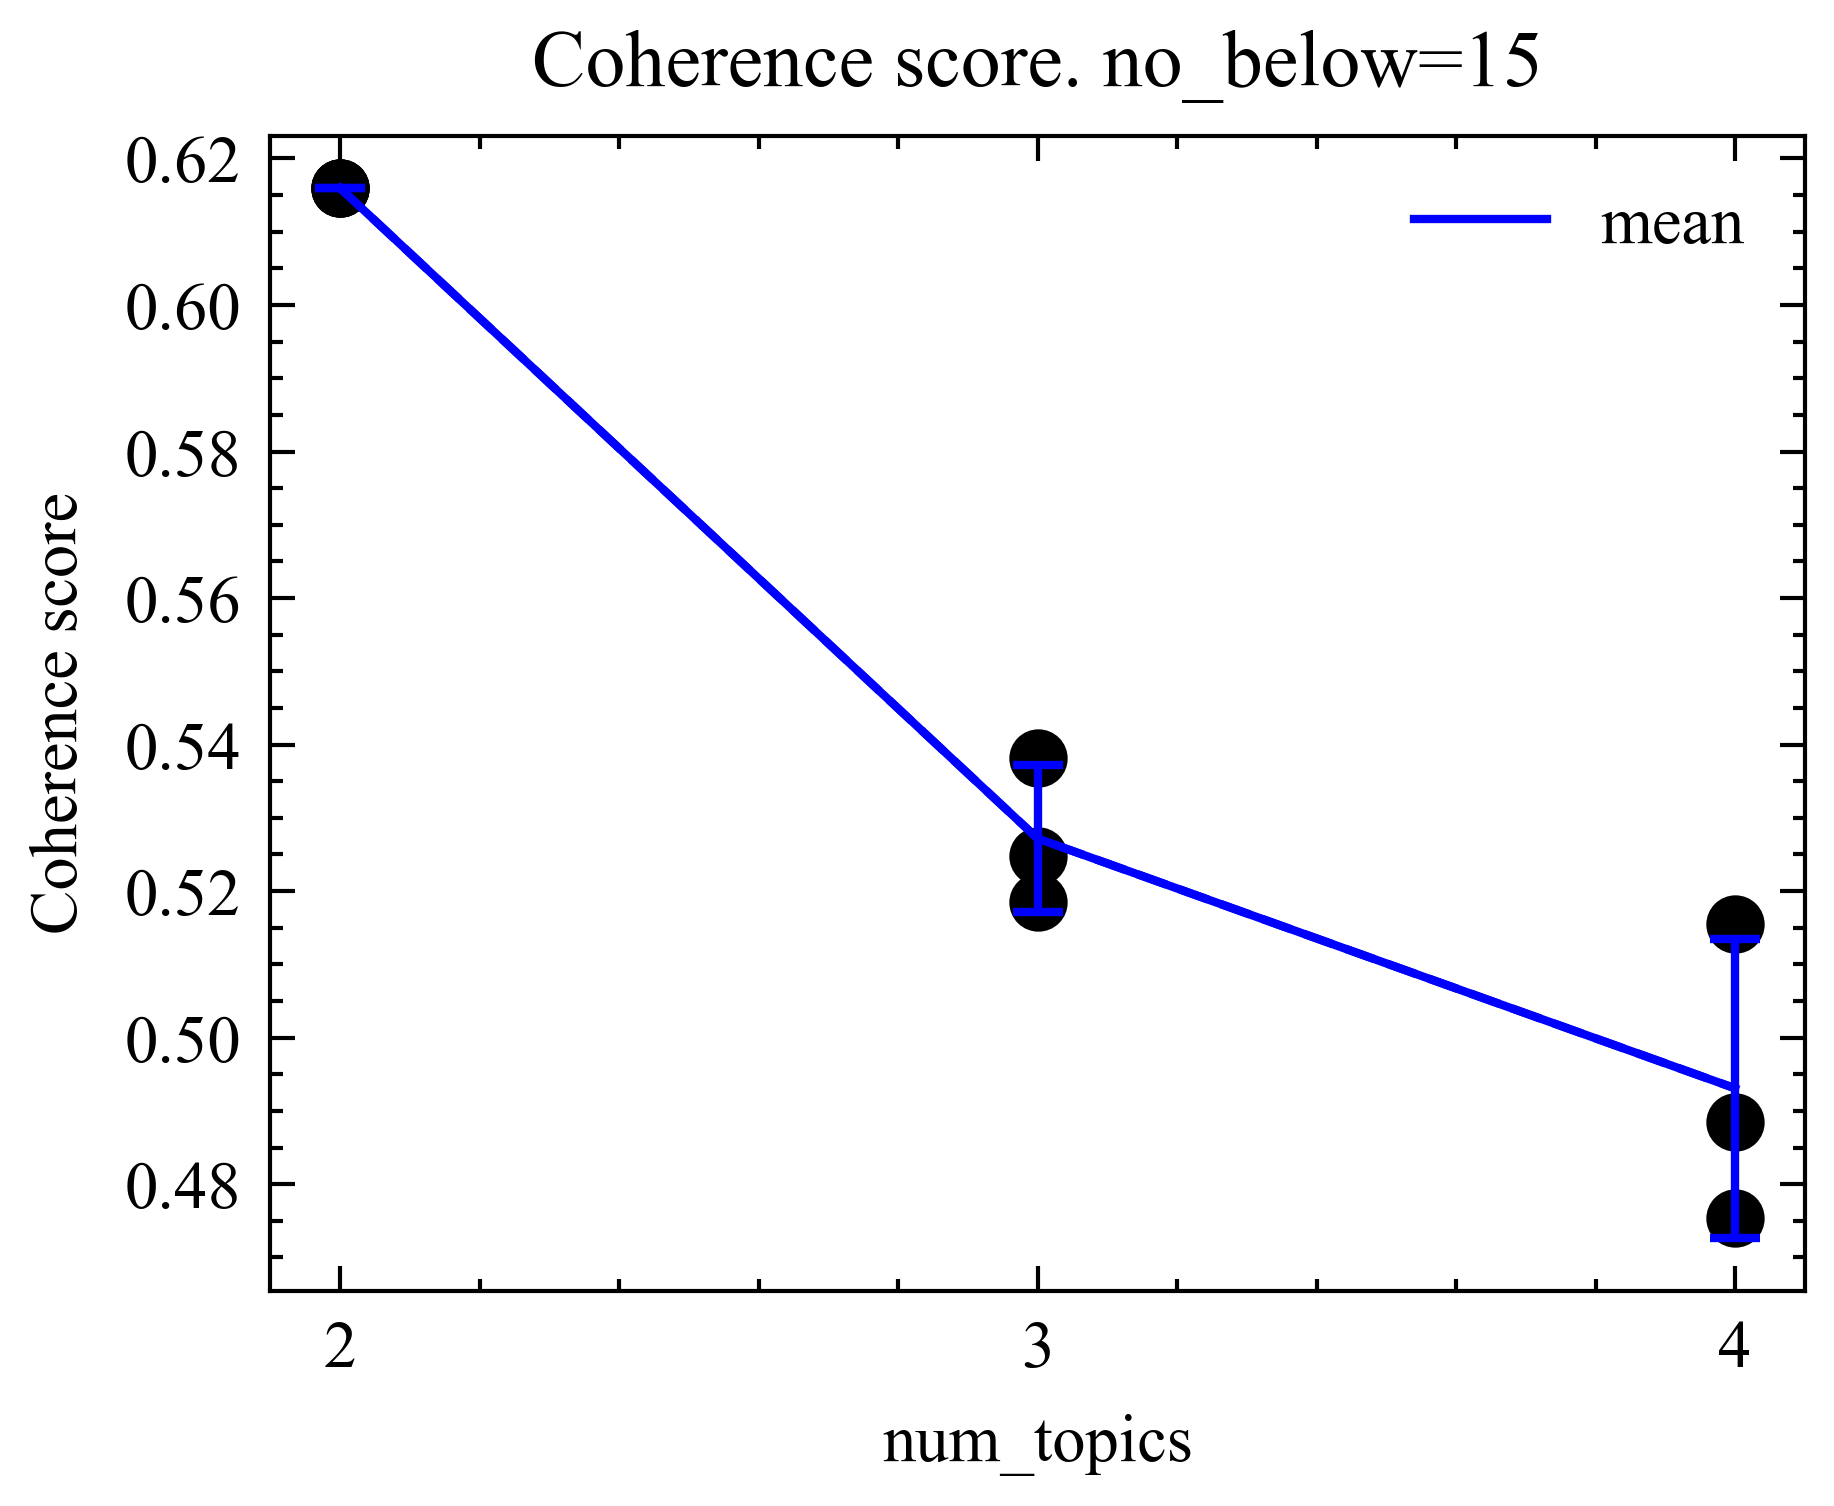

In [9]:
import scienceplots
import matplotlib


plt.style.use(['science', 'ieee','no-latex'])
matplotlib.rc('font', family='times new roman')
gridsearch_plot(df_2_topics_gridsearch)

In [20]:
df.loc[30:40]

,num_topics,coherence,model,seed,no_below,no_above
30,23.0,0.409717,"LdaModel(num_terms=726, num_topics=23, decay=0...",330.0,15,0.5
31,23.0,0.382962,"LdaModel(num_terms=726, num_topics=23, decay=0...",331.0,15,0.5
32,23.0,0.398138,"LdaModel(num_terms=726, num_topics=23, decay=0...",332.0,15,0.5
33,23.0,0.395045,"LdaModel(num_terms=726, num_topics=23, decay=0...",333.0,15,0.5
34,23.0,0.401791,"LdaModel(num_terms=726, num_topics=23, decay=0...",334.0,15,0.5
35,23.0,0.379018,"LdaModel(num_terms=726, num_topics=23, decay=0...",335.0,15,0.5
36,23.0,0.396314,"LdaModel(num_terms=726, num_topics=23, decay=0...",336.0,15,0.5
37,23.0,0.416650,"LdaModel(num_terms=726, num_topics=23, decay=0...",337.0,15,0.5
38,23.0,0.360837,"LdaModel(num_terms=726, num_topics=23, decay=0...",338.0,15,0.5
39,23.0,0.396822,"LdaModel(num_terms=726, num_topics=23, decay=0...",339.0,15,0.5


In [ ]:
df.loc[83].model.print_topics(num_words=10,num_topics=25)

In [21]:
df.loc[84].model.print_topics(num_words=10,num_topics=20)

[(6,
  '0.001*"white" + 0.001*"filter" + 0.001*"tungsten" + 0.001*"null" + 0.001*"detector" + 0.001*"hydrogen" + 0.001*"transition" + 0.001*"telescope" + 0.001*"gaussian" + 0.001*"stage"'),
 (3,
  '0.001*"null" + 0.001*"filter" + 0.001*"tungsten" + 0.001*"white" + 0.001*"detector" + 0.001*"transition" + 0.001*"stage" + 0.001*"interferogram" + 0.001*"telescope" + 0.001*"laser"'),
 (4,
  '0.001*"white" + 0.001*"transition" + 0.001*"telescope" + 0.001*"detector" + 0.001*"tungsten" + 0.001*"null" + 0.001*"hydrogen" + 0.001*"balmer_serie" + 0.001*"filter" + 0.001*"gradient"'),
 (16,
  '0.001*"orbital" + 0.001*"meaning" + 0.001*"short" + 0.001*"issue" + 0.001*"several" + 0.001*"lens" + 0.001*"less" + 0.001*"consequently" + 0.001*"problem" + 0.001*"gradient"'),
 (19,
  '0.001*"filter" + 0.001*"white" + 0.001*"telescope" + 0.001*"null" + 0.001*"transition" + 0.001*"tungsten" + 0.001*"hydrogen" + 0.001*"setup" + 0.001*"focus" + 0.001*"able"'),
 (17,
  '0.001*"white" + 0.001*"filter" + 0.001*"tu

In [22]:
def parse_topic_list(raw_topic_list):
    """Function to take the topic list, and output just the words without weights. Used for visual inspection of topic correspondence"""
    final_topic_list = []
    for topic in raw_topic_list:
        final_topic_list.append([word[0] for word in topic[1]])
        
    return final_topic_list

In [23]:
df.loc[23].model.get_topics()

array([[7.8187571e-05, 8.4887324e-03, 7.8192497e-05, ..., 7.8191486e-05,
        7.8191471e-05, 7.8182398e-05],
       [2.5764424e-05, 2.6013890e-05, 2.5763919e-05, ..., 2.5761577e-05,
        2.5763689e-05, 2.5760453e-05],
       [1.5369168e-04, 1.5369730e-04, 1.5369184e-04, ..., 1.5371799e-04,
        4.1844463e-03, 1.5368214e-04],
       ...,
       [1.4850395e-02, 1.5126127e-03, 2.5061197e-03, ..., 6.3295040e-05,
        6.3292959e-05, 6.3289495e-05],
       [7.9849118e-04, 8.5248384e-06, 2.1221787e-03, ..., 8.3523692e-06,
        8.3537789e-06, 8.3516616e-06],
       [8.5752335e-04, 1.7037207e-03, 1.0598565e-03, ..., 2.8427555e-03,
        6.1813225e-03, 9.5119287e-04]], dtype=float32)

In [24]:
model1 = df.loc[23].model
model2 = df.loc[24].model
diffmatrix = model1.diff(model2)

In [25]:
[np.argmin(line) for line in diffmatrix[0]]

[10,
 21,
 13,
 17,
 8,
 8,
 21,
 7,
 17,
 8,
 21,
 7,
 21,
 15,
 7,
 1,
 21,
 8,
 7,
 7,
 8,
 12,
 15]

In [26]:
model2.print_topics(num_topics=50)

[(0,
  '0.063*"filter" + 0.056*"tungsten" + 0.045*"contain" + 0.044*"fact" + 0.030*"piece" + 0.028*"area" + 0.028*"yellow" + 0.026*"card" + 0.024*"resolution" + 0.024*"average"'),
 (1,
  '0.185*"run" + 0.045*"second" + 0.034*"accept" + 0.030*"seem" + 0.023*"less" + 0.022*"clearly" + 0.021*"spread" + 0.020*"attempt" + 0.019*"hence" + 0.019*"develop"'),
 (2,
  '0.110*"profile" + 0.024*"white" + 0.023*"fourier_transform" + 0.018*"tungsten" + 0.016*"hence" + 0.014*"stage" + 0.014*"predict" + 0.013*"test" + 0.012*"initial" + 0.011*"gaussian"'),
 (3,
  '0.001*"white" + 0.001*"tungsten" + 0.001*"telescope" + 0.001*"null" + 0.001*"gaussian" + 0.001*"detector" + 0.001*"filter" + 0.001*"yellow" + 0.001*"interferogram" + 0.001*"hydrogen"'),
 (4,
  '0.001*"white" + 0.001*"tungsten" + 0.001*"null" + 0.001*"detector" + 0.001*"filter" + 0.001*"stage" + 0.001*"laser" + 0.001*"gaussian" + 0.001*"yellow" + 0.001*"interferogram"'),
 (5,
  '0.001*"null" + 0.001*"filter" + 0.001*"tungsten" + 0.001*"white" 

In [27]:
#establish the two models
model1 = df.loc[23].model
model2 = df.loc[21].model

diffmatrix = model1.diff(model2) #create the diff matrix
loc_overlap = [np.argmin(line) for line in diffmatrix[0]] #find the locations of the most overlapping topics

#testlist = parse_topic_list(model1.show_topics(formatted=False)) #create a formatted list of the words

for i, j in enumerate(loc_overlap): #iterate through the number of topics in the examined section of the matrix
    print("Topic from model 1: ", parse_topic_list(model1.show_topics(num_topics=50,formatted=False))[i]) 
    print("Topic from model 2: ", parse_topic_list(model2.show_topics(num_topics=50,formatted=False))[j], '\n')

Topic from model 1:  ['several', 'hence', 'main', 'resolution', 'way', 'sensitivity', 'second', 'improve', 'phenomenon', 'furthermore']
Topic from model 2:  ['stage', 'tungsten', 'white', 'null', 'filter', 'detector', 'gaussian', 'present', 'laser', 'fourier_transform'] 

Topic from model 1:  ['filter', 'beamsplitter', 'tungsten', 'null', 'detector', 'experimental', 'optical', 'step', 'gaussian', 'central']
Topic from model 2:  ['tungsten', 'filter', 'white', 'null', 'gaussian', 'detector', 'curve', 'distribution', 'yellow', 'haidinger'] 

Topic from model 1:  ['hence', 'camera', 'degree', 'perhaps', 'repeat', 'transition', 'simple', 'note', 'sodium', 'collimator']
Topic from model 2:  ['tungsten', 'hydrogen', 'transition', 'white', 'collimator', 'telescope', 'null', 'focus', 'filter', 'image'] 

Topic from model 1:  ['hydrogen', 'balmer_serie', 'estimate', 'average', 'random', 'experimental', 'associate', 'resolution', 'atom', 'able']
Topic from model 2:  ['telescope', 'hydrogen', 'tr

In [28]:
len(loc_overlap)-len(np.unique(loc_overlap))
print(loc_overlap)
print(np.unique(loc_overlap))

13

[22, 15, 11, 13, 20, 22, 14, 4, 13, 20, 20, 8, 20, 13, 4, 21, 20, 14, 19, 4, 20, 14, 13]
[ 4  8 11 13 14 15 19 20 21 22]
